<a href="https://colab.research.google.com/github/MaureenGatu/-Gender-Based-Violence-Tweets-Classification/blob/main/Gender_Based_Violence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries

In [ ]:
! python -m spacy download en_core_web_sm

     |██████▏                         | 2.3 MB 5.1 MB/s eta 0:00:02
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/lib/python3.7/subprocess.py", line 1653, in _wait
    (pid, sts) = self._try_wait(0)
  File "/usr/lib/python3.7/subprocess.py", line 1611, in _try_wait
    (pid, sts) = os.waitpid(self.pid, wait_flags)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/spacy/__main__.py", line 33, in <module>
    plac.call(commands[command], sys.argv[1:])
  File "/usr/local/lib/python3.7/dist-packages/plac_core.py", line 367, in call
    cmd, result = parser.consume(arglist)
  File "/usr/local/lib/python3.7/dist-packages/plac_core.py", line 232, in consume

In [ ]:
! pip install sparknlp

     |████████████████████████████████| 116 kB 5.5 MB/s 


In [ ]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

import spacy
#import sparknlp

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Loading the data

In [ ]:
#uploading the data

df_train= pd.read_csv('/content/Train.csv')
df_test=pd.read_csv('/content/Test.csv')
df_train.head(15)

,Tweet_ID,tweet,type
0,ID_0022DWKP,Had a dream i got raped last night. By a guy i...,sexual_violence
1,ID_00395QYM,he thought the word raped means sex and told m...,sexual_violence
2,ID_003EOSSF,She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...,sexual_violence
3,ID_004BBHOD,I was sexually abused for 3 years at age 4 to ...,sexual_violence
4,ID_004F7516,Chessy Prout can do better by telling the trut...,sexual_violence
5,ID_0052TYKI,"Yes men rape women. But women also rape men, y...",sexual_violence
6,ID_0058QG76,"My Husband Beats Me Frequently, Wife Tells Cou...",Physical_violence
7,ID_005VM1DJ,Pretty sure he raped a 16yr old girl with 2 fr...,sexual_violence
8,ID_0060BW8R,TW sorry to hear that and yeah he recently th...,sexual_violence
9,ID_007FAIEI,"""I understand that... My father was abusive as...",sexual_violence


sexual_violence                 32648
Physical_violence                5946
emotional_violence                651
economic_violence                 217
Harmful_Traditional_practice      188
Name: type, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


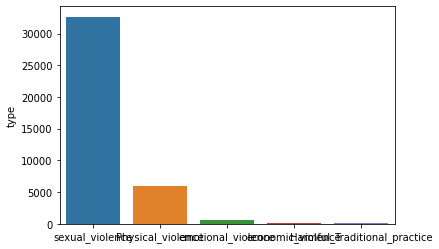

In [ ]:
# view the prediction categories
import seaborn as sns
x=df_train['type'].value_counts()
print(x)
sns.barplot(x.index,x)

## Preprocessing

In [ ]:
# df_train['type'] = df_train['type'].map({'sexual_violence': 0, 'Physical_violence': 1, 'emotional_violence': 2,
#                              'Harmful_Traditional_practice': 3, 'economic_violence': 4})
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_train['type'] = le.fit_transform(df_train['type'])

In [ ]:
#1. WORD-COUNT
df_train['word_count'] = df_train['tweet'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['type']==0]['word_count'].mean()) #Abuse tweets
print(df_train[df_train['type']==1]['word_count'].mean()) #Non-Disaster tweets
print(df_train[df_train['type']==2]['word_count'].mean()) 
print(df_train[df_train['type']==3]['word_count'].mean()) 
print(df_train[df_train['type']==4]['word_count'].mean()) 
print('***'*30)
#Disaster tweets are more wordy than the non-disaster tweets

#2. CHARACTER-COUNT
df_train['char_count'] = df_train['tweet'].apply(lambda x: len(str(x)))
print(df_train[df_train['type']==0]['char_count'].mean()) #Disaster tweets
print(df_train[df_train['type']==1]['char_count'].mean())
print(df_train[df_train['type']==2]['char_count'].mean())
print(df_train[df_train['type']==3]['char_count'].mean())
print(df_train[df_train['type']==4]['char_count'].mean())
print('***'*30) #Non-Disaster tweets
#Disaster tweets are longer than the non-disaster tweets

#3. UNIQUE WORD-COUNT
df_train['unique_word_count'] = df_train['tweet'].apply(lambda x: len(set(str(x).split())))
print(df_train[df_train['type']==0]['unique_word_count'].mean()) #Disaster tweets
print(df_train[df_train['type']==1]['unique_word_count'].mean()) #Non-Disaster tweets
print(df_train[df_train['type']==2]['unique_word_count'].mean())
print(df_train[df_train['type']==3]['unique_word_count'].mean())
print(df_train[df_train['type']==4]['unique_word_count'].mean())

33.920212765957444
23.301883619239824
40.534562211981566
38.48233486943165
41.74981622151434
******************************************************************************************
191.7659574468085
122.67574840228725
205.38248847926266
202.65284178187403
213.30792085273217
******************************************************************************************
30.22340425531915
21.474100235452404
34.31336405529954
33.78033794162826
36.008208772359716


In [ ]:
df_train.isna().sum()

Tweet_ID             0
tweet                0
type                 0
word_count           0
char_count           0
unique_word_count    0
dtype: int64

In [ ]:
# Converting all characters in the message to lower case
# 
df_train['clean_text'] = df_train['tweet']
df_train['clean_text'] = df_train['clean_text'].map(lambda x: x.lower())

# Removing any punctuation
# 
df_train['clean_text'] = df_train['clean_text'].str.replace('[^\w\s_]', '')

# Removing numbers from strings of speciafied 
# Column, here 'tweet'
df_train['clean_text'] = df_train['clean_text'].str.replace('\d+', '')

# nlp = spacy.load('en')

# df_train['clean_text2']  = df_train['clean_text'].apply(lambda x: nlp(x))

df_train.sample(5)

,Tweet_ID,tweet,type,word_count,char_count,unique_word_count,clean_text
13062,ID_BU2T4MLV,SHOCKING: Wife reveals at Court- 'My Husband B...,1,18,104,18,shocking wife reveals at court my husband beat...
35988,ID_WSGOOLDF,"A girl got coerced and raped at 14...but no, ""...",4,45,221,39,a girl got coerced and raped at but no me i wa...
19083,ID_HE0SMU3J,Racist. He calls covid the kung-flu and china ...,4,31,151,27,racist he calls covid the kungflu and china vi...
34587,ID_VI61FRM3,my dad just said that if i got raped he’d want...,4,17,73,17,my dad just said that if i got raped hed want ...
1759,ID_1KHJTO56,I am begging you for help. Is it possible to i...,4,42,189,36,i am begging you for help is it possible to im...


In [ ]:
df_train['clean_text2']  = df_train['clean_text']
df_train.drop(['clean_text2'], axis=1, inplace= True)
df_train.sample(5)

,Tweet_ID,tweet,type,word_count,char_count,unique_word_count,clean_text
34296,ID_V8SSQ7RT,I lived there ... i took those pictures of Lob...,4,38,193,37,i lived there i took those pictures of lobo a...
15001,ID_DMURNVDA,"Jorge wrote his name down on this and put ""mil...",4,53,286,47,jorge wrote his name down on this and put mill...
5839,ID_59IDSCC7,How bad has it gotten in our land? This doesn...,4,21,106,21,how bad has it gotten in our land this doesnt...
2936,ID_2NHE1D5E,"Anyway, my rapists name is Joshua Deguzman. He...",4,60,279,43,anyway my rapists name is joshua deguzman he u...
5725,ID_55BNU2KD,Yea men have gone through it but I’d bet y’all...,4,59,284,50,yea men have gone through it but id bet yall a...


In [ ]:
# # PLOTTING WORD-COUNT
# import matplotlib.pyplot as plt

# fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
# train_words=df_train[df_train['type']==1]['tweet']
# ax1.hist(train_words,color='red')
# ax1.set_title('Disaster tweets')
# train_words=df_train[df_train['type']==0]['tweet']
# ax2.hist(train_words,color='green')
# ax2.set_title('Non-disaster tweets')
# fig.suptitle('Words per tweet')
# plt.show()

from nltk.util import ngrams
from spacy.lang.en import English

nlp = English()

In [ ]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    text = re.sub("@\S+", "", text)
    re.sub("\$", "", text)
    text = re.sub("https?:\/\/.*[\r\n]*", "", text)
    re.sub("#", "", text)
    return text


#tokenizer, pos tagging and entity recognition

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['tweet'].apply(lambda x: finalpreprocess(x))
df_train.head()

,Tweet_ID,tweet,type,word_count,char_count,unique_word_count,clean_text
0,ID_0022DWKP,Had a dream i got raped last night. By a guy i...,4,45,203,40,dream get rap last night guy work actually guy...
1,ID_00395QYM,he thought the word raped means sex and told m...,4,21,100,20,think word rap mean sex tell saw dog rap eacho...
2,ID_003EOSSF,She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...,4,24,104,23,talk rap men molest jail nother charge say word
3,ID_004BBHOD,I was sexually abused for 3 years at age 4 to ...,4,61,280,50,sexually abused year age one believe rap bros ...
4,ID_004F7516,Chessy Prout can do better by telling the trut...,4,52,278,44,chessy prout good tell truth sell owen labrie ...


In [ ]:
#preprocessing test data
df_test['clean_text'] = df_test['tweet'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text']

In [ ]:

# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index2word, model.wv.syn0))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # Remove the CWD from sys.path while we load stuff.


## Vectorizing

In [ ]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"


X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"],
                                                  df_train["type"],
                                                  test_size=0.05,
                                                  shuffle=True,
                                                  stratify =df_train["type"] )
X_train_tok= [nltk.sent_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.sent_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True, )
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

## Modeling

## Logistic Regression

### base model

In [ ]:
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

from pprint import pprint
pprint(lr_tfidf.get_params)

<bound method BaseEstimator.get_params of LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)>


In [ ]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_val, y_predict))
 
baselog_accuracy = accuracy_score(y_val, y_predict)

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.99      1.00      0.99       332
           2       0.86      0.75      0.80         8
           3       1.00      1.00      1.00        43
           4       1.00      1.00      1.00      1590

    accuracy                           1.00      1983
   macro avg       0.97      0.91      0.94      1983
weighted avg       1.00      1.00      1.00      1983

Confusion Matrix:
 [[   8    0    0    0    2]
 [   0  331    0    0    1]
 [   0    0    6    0    2]
 [   0    0    0   43    0]
 [   0    3    1    0 1586]]


In [ ]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_val, y_predict))
 
baselog_accuracy = accuracy_score(y_val, y_predict)

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.98      0.99      0.98       277
           2       0.92      0.92      0.92        13
           3       1.00      0.90      0.95        30
           4       0.99      1.00      1.00      1653

    accuracy                           0.99      1983
   macro avg       0.98      0.94      0.96      1983
weighted avg       0.99      0.99      0.99      1983



TypeError: ignored

In [ ]:

#Testing it on new dataset with the best model
#df_test=pd.read_csv('test.csv')  #reading the data

#preprocessing
#df_test['clean_text'] = df_test['tweet'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'] 

#text to vector
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict = lr_tfidf.predict(X_vector)      #use the trained model on X_vector
#y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
#df_test['predict_prob']= y_prob
y_predict = le.inverse_transform(y_predict)
df_test['type']= y_predict
print(df_test.head())

.drop([ 'tweet', 'clean_text',], axis = 1, inplace = True)
attempt1.to_csv('Log_submission.csv')

SyntaxError: ignored

In [ ]:
attempt1 = df_test.copy(deep=True)

In [ ]:
attempt1.columns

In [ ]:
attempt1.drop([ 'tweet', 'clean_text',], axis = 1, inplace = True)


In [ ]:
attempt1.to_csv('Log_submission.csv')

### class imbalance

In [ ]:
# # Import the libraries
# from sklearn.datasets import make_classification

# from imblearn.over_sampling import SVMSMOTE
# lr_tfidf = SVMSMOTE(random_state = 101)

# # Choosing a sample
# X_oversample_svm, y_oversample_svm = make_classification(n_samples=10000, n_features=2,
#                                                          n_redundant=0, n_clusters_per_class=1,
#                                                          weights=[0.99], flip_y=0, random_state=101)

# # Perform Logistic Regression
# X_oversample_svm, y_oversample_svm = lr_tfidf.fit_resample(X_train_vectors_tfidf, y_train)
# classifier_svm = LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
# classifier_svm.fit(X_oversample_svm, y_oversample_svm)

# #Predict y value for test dataset
# y_predict = classifier_svm.predict(X_val_vectors_tfidf)
# y_prob = classifier_svm.predict_proba(X_val_vectors_tfidf)[:,1]
 

# print(classification_report(y_val, y_predict))
# print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 

# #print(classification_report(y_test, classifier_svm.predict(X_test)))
# accuracy_score(y_val, y_predict)

In [ ]:
# Import the libraries
from sklearn.datasets import make_classification

from imblearn.over_sampling import SVMSMOTE
lr_tfidf = SVMSMOTE(random_state = 101)

# Choosing a sample
X_oversample_svm, y_oversample_svm = make_classification(n_samples=10000, n_features=2,
                                                         n_redundant=0, n_clusters_per_class=1,
                                                         weights=[0.99], flip_y=0, random_state=101)

# Perform Logistic Regression
X_oversample_svm, y_oversample_svm = lr_tfidf.fit_resample(X_train_vectors_tfidf, y_train)
classifier_svm = LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
classifier_svm.fit(X_oversample_svm, y_oversample_svm)

#Predict y value for test dataset
y_predict = classifier_svm.predict(X_val_vectors_tfidf)
y_prob = classifier_svm.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val, y_predict))
#print('Confusion Matrix:',confusion_matrix(y_val, y_predict))              #Model score zindi : 0.761446298673513
 

#print(classification_report(y_test, classifier_svm.predict(X_test)))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       0.99      1.00      0.99       297
           2       1.00      1.00      1.00        11
           3       0.97      1.00      0.99        33
           4       1.00      1.00      1.00      1633

    accuracy                           1.00      1983
   macro avg       0.97      1.00      0.98      1983
weighted avg       1.00      1.00      1.00      1983



In [ ]:
accuracy_score(y_val, y_predict)

0.9969742813918305

In [ ]:
#text to vector
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict_ps = classifier_svm.predict(X_vector)      #use the trained model on X_vector


y_predict_ps = le.inverse_transform(y_predict_ps)

df_test['type']= y_predict_ps
dff = df_test.copy()

df_test

,Tweet_ID,tweet,clean_text,type
0,ID_0095QL4S,"because he was my boyfriend, and if I said no,...",boyfriend say would get mad hat sex force sex ...,sexual_violence
1,ID_00DREW5O,"lol no, I'm telling you it's not legal. It's l...",lol tell legal literally crime conversation ra...,Harmful_Traditional_practice
2,ID_00E9F5X9,Somalia's semi-autonomous Puntland region has ...,somalia semi autonomous puntland region take f...,Harmful_Traditional_practice
3,ID_00G9OSKZ,University of Cape Coast students being robbed...,university cape coast student rob rap armed ro...,sexual_violence
4,ID_00HU96U6,"""Somebody came up behind him and stabbed him i...",somebody come behind stab back really long bla...,sexual_violence
...,...,...,...,...
15576,ID_ZZR1D21T,A Teesside charity has filed a “super complain...,teesside charity file super complaint allege s...,Harmful_Traditional_practice
15577,ID_ZZSQF54Y,he ... forced me to have sex with him.,force sex,sexual_violence
15578,ID_ZZTN5126,Female student of medical university raped at ...,female student medical university rap gunpoint...,sexual_violence
15579,ID_ZZWS0XZZ,Bokamoso Mpembe (20 months) (Kidnapped and kil...,bokamoso mpembe month kidnap kill mother ex bo...,sexual_violence


In [ ]:
dff.drop([ 'tweet', 'clean_text'], axis = 1, inplace = True)
dff.set_index('Tweet_ID', inplace=True)
#df_test['type']= y_predict_ps
dff

,type
Tweet_ID,
ID_0095QL4S,sexual_violence
ID_00DREW5O,Harmful_Traditional_practice
ID_00E9F5X9,Harmful_Traditional_practice
ID_00G9OSKZ,sexual_violence
ID_00HU96U6,sexual_violence
...,...
ID_ZZR1D21T,Harmful_Traditional_practice
ID_ZZSQF54Y,sexual_violence
ID_ZZTN5126,sexual_violence


In [ ]:
dff.to_csv('Log_strfd_PS2.csv')

### MultiNomialNB Classifier

In [ ]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
#It's a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
# print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       1.00      0.42      0.59       294
           2       0.00      0.00      0.00        12
           3       1.00      0.07      0.13        29
           4       0.88      1.00      0.94      1632

    accuracy                           0.89      1983
   macro avg       0.58      0.30      0.33      1983
weighted avg       0.89      0.89      0.86      1983



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest = forest.fit(X_train_vectors_tfidf, y_train)
y_pred_forest = forest.predict(X_val_vectors_tfidf)

forest_accuracy = accuracy_score(y_val, y_pred_forest)
print(model_accuracy)

# We've gotten a classification rate of 95.61%. This is a pretty good accuracy score 

# For further evaluation you can also check the confusion matrix
# confusion_matrix = confusion_matrix(y_val, y_pred_forest)
# confusion_matrix

0.9919314170448815


In [ ]:
print(classification_report(y_val, y_pred_forest))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.97      0.99       277
           2       1.00      0.69      0.82        13
           3       1.00      0.87      0.93        30
           4       0.99      1.00      1.00      1653

    accuracy                           0.99      1983
   macro avg       1.00      0.89      0.94      1983
weighted avg       0.99      0.99      0.99      1983



In [ ]:
print(forest_accuracy)

0.9919314170448815


In [ ]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(forest.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train_vectors_tfidf, y_train)

### Support Vector Machine

#### Linear

In [ ]:
# Import Suport Vector Classifier module from svm library. We'll use SVC to model our data
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import train_test_split
# Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import  accuracy_score
from sklearn.metrics import confusion_matrix

from imblearn.combine import SMOTETomek
from collections import Counter

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# counter = Counter(y_train)
# print('Before',counter)

In [ ]:
# smt = SMOTETomek(random_state=139)
# X_train_vectors_tfidf_smtom,y_train_smtom = smt.fit_resample(X_train_vectors_tfidf, y_train)
# counter = Counter(y_train_smtom)
# print("After",counter)

In [ ]:
# Fit the model
svm = SVC(kernel= 'linear', class_weight = 'balanced', C = 1.0, random_state = 10)
svm.fit(X_train_vectors_tfidf, y_train)



SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=10, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
pprint(svm.get_params)

<bound method BaseEstimator.get_params of SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=10, shrinking=True, tol=0.001,
    verbose=False)>


In [ ]:
y_pred_svm = svm.predict(X_val_vectors_tfidf)

model_accuracy_1= accuracy_score(y_val, y_pred_svm)
print(model_accuracy_1)

# We've gotten a classification rate of 95.61%. This is a pretty good accuracy score 

# For further evaluation you can also check the confusion matrix
confusion_matrix = confusion_matrix(y_val, y_pred_svm)
confusion_matrix

In [ ]:
# Fit the model
svm = SVC(kernel= 'linear', class_weight = 'balanced', C = 0.01, gamma = 'auto')
svm.fit(X_train_vectors_tfidf, y_train)

y_pred_svm2 = svm.predict(X_val_vectors_tfidf)



In [ ]:
# model_accuracy_2= accuracy_score(y_val, y_pred_svm2)
# print(model_accuracy_2)

# # We've gotten a classification rate of 95.61%. This is a pretty good accuracy score 
                                                                                          #zindi model accuracy = 0.7267864783911
# # For further evaluation you can also check the confusion matrix
# confusion_matrix = confusion_matrix(y_val, y_pred_svm2)
# confusion_matrix

0.9863842662632375


array([[  10,    0,    0,    0,    0],
       [   1,  323,    0,    0,    8],
       [   0,    0,    8,    0,    0],
       [   0,    0,    0,   43,    0],
       [   2,    7,    5,    4, 1572]])

In [ ]:
model_accuracy_2= accuracy_score(y_val, y_pred_svm2)
print(model_accuracy_2)

# We've gotten a classification rate of 95.61%. This is a pretty good accuracy score 

# For further evaluation you can also check the confusion matrix
confusion_matrix = confusion_matrix(y_val, y_pred_svm2)
confusion_matrix

0.9813414019162885


TypeError: ignored

In [ ]:
# Fit the model
svm = SVC(kernel= 'linear', class_weight = 'balanced', C = 0.01, gamma = 'auto')
svm.fit(X_train_vectors_tfidf, y_train)

y_pred_svm2 = svm.predict(X_val_vectors_tfidf)

model_accuracy_2= accuracy_score(y_val, y_pred_svm2)
print(model_accuracy)

# We've gotten a classification rate of 95.61%. This is a pretty good accuracy score 

# For further evaluation you can also check the confusion matrix
confusion_matrix = confusion_matrix(y_val, y_pred_svm2)
confusion_matrix

0.9919314170448815


TypeError: ignored

In [ ]:
df_test['clean_text'] = df_test['tweet'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'] 



In [ ]:
#text to vector
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict_svm = svm.predict(X_vector)      #use the trained model on X_vector
#y_prob = svm.predict_proba(X_vector)[:,1]
#df_test['predict_prob']= y_prob
y_predict_svm = le.inverse_transform(y_predict_svm)
#final.to_csv('SVM.csv')

In [ ]:
df_test['type']= y_predict_svm
df_test

,Tweet_ID,tweet,clean_text,type
0,ID_0095QL4S,"because he was my boyfriend, and if I said no,...",boyfriend say would get mad hat sex force sex ...,sexual_violence
1,ID_00DREW5O,"lol no, I'm telling you it's not legal. It's l...",lol tell legal literally crime conversation ra...,Harmful_Traditional_practice
2,ID_00E9F5X9,Somalia's semi-autonomous Puntland region has ...,somalia semi autonomous puntland region take f...,Harmful_Traditional_practice
3,ID_00G9OSKZ,University of Cape Coast students being robbed...,university cape coast student rob rap armed ro...,sexual_violence
4,ID_00HU96U6,"""Somebody came up behind him and stabbed him i...",somebody come behind stab back really long bla...,sexual_violence
...,...,...,...,...
15576,ID_ZZR1D21T,A Teesside charity has filed a “super complain...,teesside charity file super complaint allege s...,Harmful_Traditional_practice
15577,ID_ZZSQF54Y,he ... forced me to have sex with him.,force sex,Harmful_Traditional_practice
15578,ID_ZZTN5126,Female student of medical university raped at ...,female student medical university rap gunpoint...,sexual_violence
15579,ID_ZZWS0XZZ,Bokamoso Mpembe (20 months) (Kidnapped and kil...,bokamoso mpembe month kidnap kill mother ex bo...,sexual_violence


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15581 entries, 0 to 15580
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tweet_ID    15581 non-null  object
 1   tweet       15581 non-null  object
 2   clean_text  15581 non-null  object
 3   type        15581 non-null  object
dtypes: object(4)
memory usage: 487.0+ KB


In [ ]:
dff = df_test.copy()
dff.drop([ 'tweet', 'clean_text'], axis = 1, inplace = True)
dff.set_index('Tweet_ID', inplace=True)
dff.head(3)

,type
Tweet_ID,
ID_0095QL4S,sexual_violence
ID_00DREW5O,Harmful_Traditional_practice
ID_00E9F5X9,Harmful_Traditional_practice


In [ ]:

dff.to_csv('Sup_Vec_strfd.csv')

#### Polynomial

In [ ]:
# Fit the model
rdf = SVC(kernel= 'rbf')
rdf.fit(X_train_vectors_tfidf, y_train)

y_pred_svm = rdf.predict(X_val_vectors_tfidf)

In [ ]:
model_accuracy = accuracy_score(y_val, y_pred_svm)
print(model_accuracy)

# We've gotten a classification rate of 95.61%. This is a pretty good accuracy score 

# For further evaluation you can also check the confusion matrix
print(classification_report(y_val,y_pred_svm))

0.9935804356132977
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        55
           1       0.99      0.99      0.99      1948
           2       0.96      0.68      0.80        66
           3       0.97      0.97      0.97       233
           4       1.00      1.00      1.00     10783

    accuracy                           0.99     13085
   macro avg       0.98      0.89      0.93     13085
weighted avg       0.99      0.99      0.99     13085



In [ ]:
#text to vector
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict_svm_p = svm.predict(X_vector)      #use the trained model on X_vector

y_predict_svm_p = le.inverse_transform(y_predict_svm_p)


In [ ]:
df_test['type']= y_predict_svm_p
print(df_test.head())
final=df_test[['Tweet_ID']].reset_index(drop=True)

      Tweet_ID  ...             type
0  ID_0095QL4S  ...  sexual_violence
1  ID_00DREW5O  ...  sexual_violence
2  ID_00E9F5X9  ...  sexual_violence
3  ID_00G9OSKZ  ...  sexual_violence
4  ID_00HU96U6  ...  sexual_violence

[5 rows x 5 columns]


In [ ]:
# df_test.info()

In [ ]:
dff = df_test.copy()
dff.drop([ 'tweet', 'clean_text','target'], axis = 1, inplace = True)
dff.set_index('Tweet_ID', inplace=True)
dff.to_csv('Support_Vector_RBF.csv')
dff

,type
Tweet_ID,
ID_0095QL4S,sexual_violence
ID_00DREW5O,sexual_violence
ID_00E9F5X9,sexual_violence
ID_00G9OSKZ,sexual_violence
ID_00HU96U6,sexual_violence
...,...
ID_ZZR1D21T,sexual_violence
ID_ZZSQF54Y,sexual_violence
ID_ZZTN5126,sexual_violence


## Neural Networks

In [ ]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes = (13, 13,13), max_iter = 500,activation='relu')

# fitting the data
mlp.fit(X_train_vectors_tfidf,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
pred = mlp.predict(X_val_vectors_tfidf)


#print(accuracy_score(X_train_vectors_tfidf,y_train))

print('-----------------------------------------------')

print(classification_report(y_val,pred))

-----------------------------------------------
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         9
           1       0.99      0.99      0.99       297
           2       1.00      0.73      0.84        11
           3       0.97      0.88      0.92        33
           4       1.00      1.00      1.00      1633

    accuracy                           0.99      1983
   macro avg       0.94      0.92      0.92      1983
weighted avg       0.99      0.99      0.99      1983



In [ ]:
# Evaluating the performance of ur model
print (confusion_matrix(y_val,pred))

[[   9    0    0    0    0]
 [   1  294    0    0    2]
 [   1    0    8    0    2]
 [   0    0    0   29    4]
 [   1    2    0    1 1629]]


In [ ]:
#text to vector
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict = lr_tfidf.predict(X_vector)      #use the trained model on X_vector
#y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
#df_test['predict_prob']= y_prob
y_predict = le.inverse_transform(y_predict)
df_test['type']= y_predict
print(df_test.head())

.drop([ 'tweet', 'clean_text',], axis = 1, inplace = True)
attempt1.to_csv('Log_submission.csv')

In [ ]:
X = df_train['clean_text']
y = df_train['type']

In [ ]:
# divide our data into 80% for the training set and 20% for the testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = )

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 5000

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(28136, 100)

In [ ]:
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import LSTM
# define problem properties
# n_timesteps = 10
# define LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#Let's plot the summary of our model.
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 5000, 100)         2813600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 5000, 256)         234496    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5000, 1)           257       
Total params: 3,048,353
Trainable params: 234,753
Non-trainable params: 2,813,600
_________________________________________________________________
None


In [ ]:
#train the model on the training set 
#and evaluate its performance on the test set.
history = model.fit(X_train, y_train, batch_size=128, epochs=11, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

# To check the test accuracy and loss we run the following code

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:

from keras.layers import Bidirectional
from keras.layers import TimeDistributed
# define problem properties
# n_timesteps = 10
# define LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#Let's plot the summary of our model.
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          2813600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          234496    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 1)            257       
Total params: 3,048,353
Trainable params: 234,753
Non-trainable params: 2,813,600
_________________________________________________________________
None


In [ ]:
#train the model on the training set 
#and evaluate its performance on the test set.
history = model.fit(X_train, y_train, batch_size=128, epochs=11, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

# To check the test accuracy and loss we run the following code

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/11
199/199 [==============================] - 9s 25ms/step - loss: -28.6449 - accuracy: 0.1501 - val_loss: -38.1262 - val_accuracy: 0.1504
Epoch 2/11
199/199 [==============================] - 4s 19ms/step - loss: -38.2164 - accuracy: 0.1492 - val_loss: -38.1334 - val_accuracy: 0.1504
Epoch 3/11
199/199 [==============================] - 4s 19ms/step - loss: -38.0226 - accuracy: 0.1540 - val_loss: -38.1358 - val_accuracy: 0.1504
Epoch 4/11
199/199 [==============================] - 4s 19ms/step - loss: -37.9745 - accuracy: 0.1545 - val_loss: -38.1367 - val_accuracy: 0.1504
Epoch 5/11
199/199 [==============================] - 4s 19ms/step - loss: -38.1240 - accuracy: 0.1520 - val_loss: -38.1371 - val_accuracy: 0.1504
Epoch 6/11
199/199 [==============================] - 4s 19ms/step - loss: -38.1718 - accuracy: 0.1506 - val_loss: -38.1371 - val_accuracy: 0.1504
Epoch 7/11
199/199 [==============================] - 4s 19ms/step - loss: -38.0372 - accuracy: 0.1539 - val_loss: -38

In [ ]:
# Import the libraries
from sklearn.datasets import make_classification

from imblearn.over_sampling import SVMSMOTE
lr_tfidf = SVMSMOTE(random_state = 101)

# Choosing a sample
X_oversample_svm, y_oversample_svm = make_classification(n_samples=10000, n_features=2,
                                                         n_redundant=0, n_clusters_per_class=1,
                                                         weights=[0.99], flip_y=0, random_state=101)

# Perform Logistic Regression
X_oversample_svm, y_oversample_svm = lr_tfidf.fit_resample(X_train_vectors_tfidf, y_train)
classifier_svm = LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
classifier_svm.fit(X_oversample_svm, y_oversample_svm)

#Predict y value for test dataset
y_predict = classifier_svm.predict(X_val_vectors_tfidf)
y_prob = classifier_svm.predict_proba(X_val_vectors_tfidf)[:,1]
 

 

#print(classification_report(y_test, classifier_svm.predict(X_test)))

In [ ]:

print(classification_report(y_val, y_predict))
print('Confusion Matrix:', confusion_matrix(y_val, y_predict))
accuracy_score(y_val, y_predict)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00       284
           2       0.67      1.00      0.80         4
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00      1657

    accuracy                           1.00      1983
   macro avg       0.93      1.00      0.96      1983
weighted avg       1.00      1.00      1.00      1983



0.9984871406959153

In [ ]:
#text to vector
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict_ps = classifier_svm.predict(X_vector)      #use the trained model on X_vector


y_predict_ps = le.inverse_transform(y_predict_ps)

df_test['type']= y_predict_ps
dff = df_test.copy()
dff.drop([ 'tweet', 'clean_text'], axis = 1, inplace = True)
dff.set_index('Tweet_ID', inplace=True)


In [ ]:
df_test['type']= y_predict_ps
dff.to_csv('Sup_Vector_PS2.csv')
df_test

,Tweet_ID,tweet,clean_text,clean_text2,type
0,ID_0095QL4S,"because he was my boyfriend, and if I said no,...",boyfriend say would get mad hat sex force sex ...,"(boyfriend, say, would, get, mad, hat, sex, fo...",sexual_violence
1,ID_00DREW5O,"lol no, I'm telling you it's not legal. It's l...",lol tell legal literally crime conversation ra...,"(lol, tell, legal, literally, crime, conversat...",Harmful_Traditional_practice
2,ID_00E9F5X9,Somalia's semi-autonomous Puntland region has ...,somalia semi autonomous puntland region take f...,"(somalia, semi, autonomous, puntland, region, ...",Harmful_Traditional_practice
3,ID_00G9OSKZ,University of Cape Coast students being robbed...,university cape coast student rob rap armed ro...,"(university, cape, coast, student, rob, rap, a...",sexual_violence
4,ID_00HU96U6,"""Somebody came up behind him and stabbed him i...",somebody come behind stab back really long bla...,"(somebody, come, behind, stab, back, really, l...",sexual_violence
...,...,...,...,...,...
15576,ID_ZZR1D21T,A Teesside charity has filed a “super complain...,teesside charity file super complaint allege s...,"(teesside, charity, file, super, complaint, al...",Harmful_Traditional_practice
15577,ID_ZZSQF54Y,he ... forced me to have sex with him.,force sex,"(force, sex)",sexual_violence
15578,ID_ZZTN5126,Female student of medical university raped at ...,female student medical university rap gunpoint...,"(female, student, medical, university, rap, gu...",sexual_violence
15579,ID_ZZWS0XZZ,Bokamoso Mpembe (20 months) (Kidnapped and kil...,bokamoso mpembe month kidnap kill mother ex bo...,"(bokamoso, mpembe, month, kidnap, kill, mother...",sexual_violence


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15581 entries, 0 to 15580
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Tweet_ID     15581 non-null  object
 1   tweet        15581 non-null  object
 2   clean_text   15581 non-null  object
 3   clean_text2  15581 non-null  object
 4   type         15581 non-null  object
dtypes: object(5)
memory usage: 608.8+ KB


In [ ]:
dff = df_test.copy()
dff.drop([ 'tweet', 'clean_text'], axis = 1, inplace = True)
dff.set_index('Tweet_ID', inplace=True)
dff.to_csv('Sup_Vector_PS2.csv')